Data Engineering

In [5]:
!pip install imblearn

In [ ]:
# Extract Data from csv
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

# Lists to store model names and metrics
model_names = ["Logistic_Regression", "Decision_Tree", "Random_Forest", "XGBoost", 
               "SVC", "KNN", "Naive_Bayes", "Neural_Network", "Gradient_Boosting", "Voting_Classifier", "KMeans"]

# Global dictionaries for metrics
metrics_train = {}
metrics_test = {}

# Initialize dictionaries for each metric for each model name
for model in model_names:
    for metric in ["accuracy", "precision", "recall", "f1_score"]:
        metrics_train[f"{metric}_{model}"] = None
        metrics_test[f"{metric}_{model}"] = None
    # Also include k-fold metrics for later
    for metric in ["accuracy", "precision", "recall", "f1_score"]:
        metrics_test[f"{metric}_kfold_{model}"] = None

# List to hold trained model objects and their names
models = []
models_name = []

# Load dataset
data = pd.read_csv("/test/over_features.csv")

# Limit dataset for speed
data = data.iloc[:10000]

# Check and drop missing values
print("Missing values in data:")
print(data.isnull().sum())
data.dropna(inplace=True)

# Remove identifier
data = data.drop(columns=["match_id"])

# Feature Engineering: enhanced features
data["pressure_index"] = data["dot_ball_pressure"] * data["required_desired_run_rate"]
data["wicket_pressure"] = data["number_of_wickets_lost"] * data["required_desired_run_rate"]
data["late_over_flag"] = (data["over"] > 15).astype(int)
data["bowler_pressure"] = data["current_bowler_economy"] * (data["bowler_wickets_in_match"] + 1)
data["aggressiveness_index"] = data["striker_strike_rate"] * (data["striker_boundaries_hit"] + 1)

print(len(data))
print(data.columns)

# Encode categorical columns
team_mapping = {team: idx for idx, team in enumerate(data["team"].unique())}
data["team_encoded"] = data["team"].map(team_mapping)

phase_mapping = {phase: idx for idx, phase in enumerate(data["match_phase"].unique())}
data["match_phase_encoded"] = data["match_phase"].map(phase_mapping)

# Drop original categorical columns and unused features
data_encoded = data.drop(columns=["team", "match_phase"])
data_encoded = data_encoded.drop(columns=["striker_boundaries_hit", "total_overs_completed"])

# Train-test split
train_data, test_data = train_test_split(data_encoded, test_size=0.2, random_state=42)

# Separate features and target
X_train = train_data.drop(columns=["wicket_next_over"])
y_train = train_data["wicket_next_over"]
X_test = test_data.drop(columns=["wicket_next_over"])
y_test = test_data["wicket_next_over"]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -------------------------------
# Balancing only the training set
# -------------------------------
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)
X_train_scaled = X_train_balanced
y_train = y_train_balanced

Missing values in data:
match_id                             0
innings                              0
team                                 0
over                                 0
balls_faced_by_striker               0
striker_strike_rate                  0
striker_boundaries_hit               0
dot_ball_pressure                    0
current_bowler_economy               0
bowler_wickets_in_match              0
total_overs_completed                0
overs_since_last_wicket              0
number_of_wickets_lost               0
required_desired_run_rate            0
current_run_rate                     0
wickets_lost_last_3_overs            0
number_of_boundaries_last_3_overs    0
number_of_dot_balls_last_over        0
powerplay_overs_remaining            0
match_phase                          0
wicket_next_over                     0
dtype: int64
10000
Index(['innings', 'team', 'over', 'balls_faced_by_striker',
       'striker_strike_rate', 'striker_boundaries_hit', 'dot_ball_pressure',
 

In [7]:
# (Optional) Data imbalance visualization placeholder
# TODO: Add plots to visualize imbalances

Feature Engineering

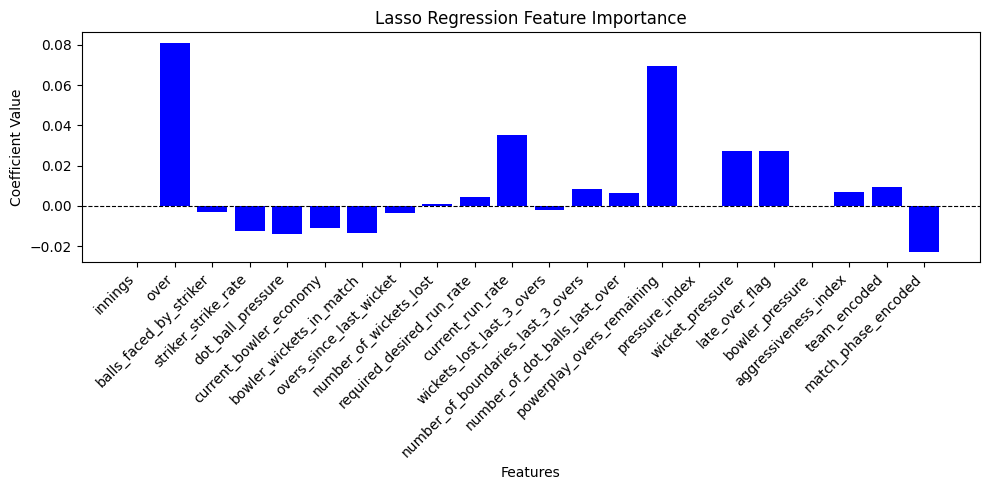

Feature Coefficients: {'innings': 8.381624992224421e-05, 'over': 0.08097197869570558, 'balls_faced_by_striker': -0.003170884740071659, 'striker_strike_rate': -0.012320005338242545, 'dot_ball_pressure': -0.014045245661864401, 'current_bowler_economy': -0.010837105548196738, 'bowler_wickets_in_match': -0.01326252857649782, 'overs_since_last_wicket': -0.0036299654135151832, 'number_of_wickets_lost': 0.0009428747285160504, 'required_desired_run_rate': 0.004662339931673641, 'current_run_rate': 0.035310949269227114, 'wickets_lost_last_3_overs': -0.0022212438801524352, 'number_of_boundaries_last_3_overs': 0.00831914558612219, 'number_of_dot_balls_last_over': 0.006219061608195104, 'powerplay_overs_remaining': 0.06953692603730247, 'pressure_index': 0.0, 'wicket_pressure': 0.027308460468796716, 'late_over_flag': 0.02726423880688006, 'bowler_pressure': 0.0, 'aggressiveness_index': 0.007125745758160518, 'team_encoded': 0.009404457995308082, 'match_phase_encoded': -0.022813640252428304}


In [8]:
# Lasso Regression for feature selection with Grid Search
from sklearn.linear_model import Lasso

alphas = np.logspace(-3, 1, 100) 
lasso = Lasso(max_iter=1000)
grid = GridSearchCV(lasso, param_grid={"alpha": alphas}, cv=5, scoring="r2")
grid.fit(X_train_scaled, y_train)

best_lasso = grid.best_estimator_
lasso_coef = best_lasso.coef_

plt.figure(figsize=(10, 5))
plt.bar(X_train.columns, lasso_coef, color='blue')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.xlabel("Features")
plt.ylabel("Coefficient Value")
plt.title("Lasso Regression Feature Importance")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("Feature Coefficients:", dict(zip(X_train.columns, lasso_coef)))

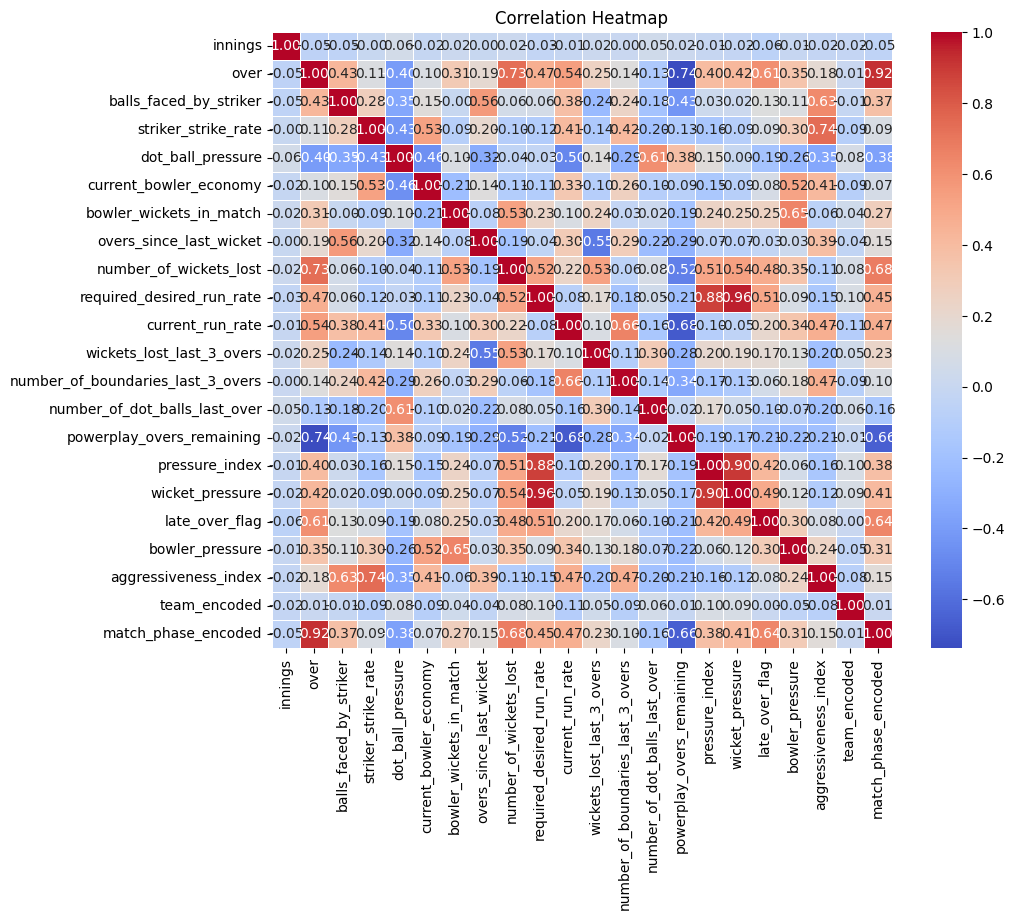

In [9]:
# Correlation heatmap
correlation_matrix = X_train.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

                              Feature  Importance
20                       team_encoded    0.067815
1                                over    0.063208
5              current_bowler_economy    0.062421
18                    bowler_pressure    0.062214
19               aggressiveness_index    0.061517
3                 striker_strike_rate    0.061399
4                   dot_ball_pressure    0.060122
2              balls_faced_by_striker    0.059349
10                   current_run_rate    0.056041
9           required_desired_run_rate    0.055552
15                     pressure_index    0.055384
7             overs_since_last_wicket    0.052608
16                    wicket_pressure    0.052114
12  number_of_boundaries_last_3_overs    0.050311
13      number_of_dot_balls_last_over    0.049428
8              number_of_wickets_lost    0.047889
6             bowler_wickets_in_match    0.019680
11          wickets_lost_last_3_overs    0.019582
0                             innings    0.013563


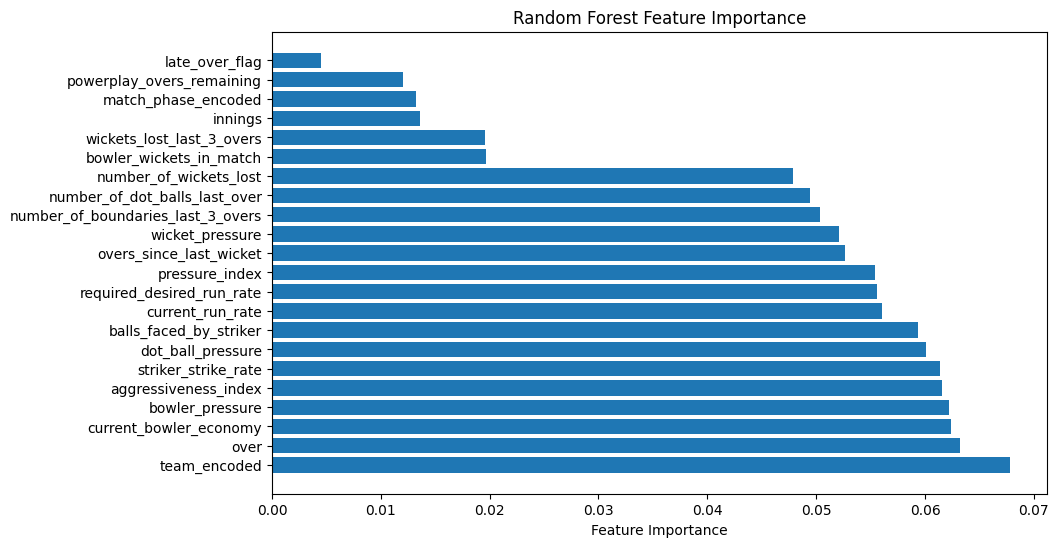

In [10]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
feature_importances = rf.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X_train.columns,  
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)

plt.figure(figsize=(10,6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.show()

Model Training

In [11]:
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    return accuracy, precision, recall, f1

def evaluate_model(y_train_true, y_train_pred, y_test_true, y_test_pred, model_name, model):
    # Store model and name
    models.append(model)
    models_name.append(model_name)
    
    # Calculate and store metrics
    accuracy_train, precision_train, recall_train, f1_train = calculate_metrics(y_train_true, y_train_pred)
    accuracy_test, precision_test, recall_test, f1_test = calculate_metrics(y_test_true, y_test_pred)
    
    metrics_train[f"accuracy_{model_name}"] = accuracy_train
    metrics_train[f"precision_{model_name}"] = precision_train
    metrics_train[f"recall_{model_name}"] = recall_train
    metrics_train[f"f1_score_{model_name}"] = f1_train

    metrics_test[f"accuracy_{model_name}"] = accuracy_test
    metrics_test[f"precision_{model_name}"] = precision_test
    metrics_test[f"recall_{model_name}"] = recall_test
    metrics_test[f"f1_score_{model_name}"] = f1_test
    
    # Run k-fold cross-validation and update metrics
    cross_validate_model(model, model_name, X_train_scaled, y_train)

def cross_validate_model(model, model_name, X, y, n_splits=5):
    average_metrics = {"accuracy": 0, "precision": 0, "recall": 0, "f1_score": 0}
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # Convert X and y to DataFrame/Series once (if needed)
    if isinstance(X, np.ndarray):
        X_df = pd.DataFrame(X, columns=X_train.columns)
    else:
        X_df = X.copy()
    if isinstance(y, np.ndarray):
        y_series = pd.Series(y)
    else:
        y_series = y.copy()
    
    k_folds = 0
    for train_index, test_index in skf.split(X_df, y_series):
        k_folds += 1
        X_train_cv = X_df.iloc[train_index]
        X_test_cv = X_df.iloc[test_index]
        y_train_cv = y_series.iloc[train_index]
        y_test_cv = y_series.iloc[test_index]
        
        model.fit(X_train_cv, y_train_cv)
        y_pred_cv = model.predict(X_test_cv)
        
        accuracy, precision, recall, f1 = calculate_metrics(y_test_cv, y_pred_cv)
        average_metrics["accuracy"] += accuracy
        average_metrics["precision"] += precision
        average_metrics["recall"] += recall
        average_metrics["f1_score"] += f1
        
    metrics_test[f"accuracy_kfold_{model_name}"] = average_metrics["accuracy"] / k_folds
    metrics_test[f"precision_kfold_{model_name}"] = average_metrics["precision"] / k_folds
    metrics_test[f"recall_kfold_{model_name}"] = average_metrics["recall"] / k_folds
    metrics_test[f"f1_score_kfold_{model_name}"] = average_metrics["f1_score"] / k_folds

def train_and_evaluate_model(model, model_name):
    model.fit(X_train_scaled, y_train)
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    evaluate_model(y_train, y_train_pred, y_test, y_test_pred, model_name, model)

In [12]:
# Logistic Regression model
model = LogisticRegression(multi_class='multinomial', max_iter=1000)
train_and_evaluate_model(model, "Logistic_Regression")

In [13]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=42)
train_and_evaluate_model(model, "Decision_Tree")

In [14]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=42)
train_and_evaluate_model(model, "Random_Forest")

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier(random_state=42)
train_and_evaluate_model(model, "Gradient_Boosting")

In [ ]:
from sklearn.svm import SVC
model = SVC(random_state=42)
train_and_evaluate_model(model, "SVC")

In [ ]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=2, random_state=42)
train_and_evaluate_model(model, "KMeans")

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=5)
train_and_evaluate_model(model, "KNN")

In [ ]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
train_and_evaluate_model(model, "Naive_Bayes")

In [ ]:
!pip install xgboost

In [ ]:
from xgboost import XGBClassifier
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
train_and_evaluate_model(model, "XGBoost")

In [ ]:
from sklearn.ensemble import VotingClassifier
model = VotingClassifier(estimators=[
    ('logistic', LogisticRegression(multi_class='multinomial', max_iter=1000)),
    ('tree', DecisionTreeClassifier(random_state=42)),
    ('forest', RandomForestClassifier(random_state=42)),
    ('boosting', GradientBoostingClassifier(random_state=42)),
    ('xgboost', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))
], voting='soft')
train_and_evaluate_model(model, "Voting_Classifier")

In [ ]:
!pip install torch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

num_features = X_train.shape[1]

class ImprovedWicketPredictor(nn.Module):
    def __init__(self, input_dim):
        super(ImprovedWicketPredictor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 8)
        self.fc5 = nn.Linear(8, 1)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.5)

        self.batch_norm1 = nn.BatchNorm1d(64)
        self.batch_norm2 = nn.BatchNorm1d(32)
        self.batch_norm3 = nn.BatchNorm1d(16)
        self.batch_norm4 = nn.BatchNorm1d(8)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.batch_norm1(x)
        x = self.dropout(x)

        x = self.relu(self.fc2(x))
        x = self.batch_norm2(x)
        x = self.dropout(x)

        x = self.relu(self.fc3(x))
        x = self.batch_norm3(x)
        x = self.dropout(x)

        x = self.relu(self.fc4(x))
        x = self.batch_norm4(x)
        x = self.fc5(x)
        x = self.sigmoid(x)
        return x

def NN_predict(X_train_df, X_test_df, Y_train_df, Y_test_df):
    # Convert DataFrames/Series to tensors
    X_train_tensor = torch.tensor(X_train_df.to_numpy(), dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_df.to_numpy(), dtype=torch.float32)
    y_train_tensor = torch.tensor(Y_train_df.to_numpy(), dtype=torch.float32).view(-1, 1)
    y_test_tensor = torch.tensor(Y_test_df.to_numpy(), dtype=torch.float32).view(-1, 1)

    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

    input_dim = X_train_df.shape[1]
    model_nn = ImprovedWicketPredictor(input_dim)

    criterion = nn.BCELoss()
    optimizer = optim.AdamW(model_nn.parameters(), lr=0.001)

    epochs = 100
    best_accuracy = 0
    patience = 10
    no_improvement = 0

    for epoch in range(epochs):
        model_nn.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model_nn(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        with torch.no_grad():
            model_nn.eval()
            y_train_pred = model_nn(X_train_tensor).round()
            accuracy = accuracy_score(y_train_tensor.numpy(), y_train_pred.numpy())
            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Training Accuracy: {accuracy:.4f}')

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            no_improvement = 0
        else:
            no_improvement += 1

        if no_improvement >= patience:
            print("Early stopping triggered.")
            break

    model_nn.eval()
    with torch.no_grad():
        y_test_pred = model_nn(X_test_tensor).round()
    return y_test_pred

# Revised NN cross-validation without needing a model parameter
def cross_validate_NN(model_name, X, y, n_splits=5):
    average_metrics = {"accuracy": 0, "precision": 0, "recall": 0, "f1_score": 0}
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # Ensure X is DataFrame and y is Series
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X, columns=X_train.columns)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    
    k_folds = 0
    for train_index, test_index in skf.split(X, y):
        k_folds += 1
        X_train_cv = X.iloc[train_index]
        X_test_cv = X.iloc[test_index]
        Y_train_cv = y.iloc[train_index]
        Y_test_cv = y.iloc[test_index]
        
        y_pred_cv = NN_predict(X_train_cv, X_test_cv, Y_train_cv, Y_test_cv)
        y_pred_binary = (y_pred_cv > 0.5).astype(int)
        accuracy, precision, recall, f1 = calculate_metrics(Y_test_cv, y_pred_binary)
        
        average_metrics["accuracy"] += accuracy
        average_metrics["precision"] += precision
        average_metrics["recall"] += recall
        average_metrics["f1_score"] += f1
    
    metrics_test[f"accuracy_kfold_{model_name}"] = average_metrics["accuracy"] / k_folds
    metrics_test[f"precision_kfold_{model_name}"] = average_metrics["precision"] / k_folds
    metrics_test[f"recall_kfold_{model_name}"] = average_metrics["recall"] / k_folds
    metrics_test[f"f1_score_kfold_{model_name}"] = average_metrics["f1_score"] / k_folds

X_all_data = data_encoded.drop(columns=["wicket_next_over"])
Y_all_data = data_encoded["wicket_next_over"]

# Evaluate NN on full data (for demonstration)
y_pred_nn = NN_predict(X_all_data, X_all_data, Y_all_data, Y_all_data)
accuracy, precision, recall, f1 = calculate_metrics(Y_all_data, y_pred_nn)
print(f'NN on All Data: Accuracy: {accuracy*100:.2f}%, Precision: {precision*100:.2f}%, Recall: {recall*100:.2f}%, F1 Score: {f1*100:.2f}%')

# Use the dedicated NN cross-validation function
cross_validate_NN("Neural_Network", X_all_data, Y_all_data, n_splits=5)
print("Neural Network Cross-validation metrics:")
for metric in ["accuracy", "precision", "recall", "f1_score"]:
    print(f"{metric}_Neural_Network: {metrics_test[f'{metric}_kfold_Neural_Network']:.4f}")

# Evaluate NN on training set
X_train_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
y_pred_train_nn = NN_predict(X_train_df, X_train_df, y_train, y_train)
accuracy, precision, recall, f1 = calculate_metrics(y_train, y_pred_train_nn)
print(f'NN on Train Data: Accuracy: {accuracy*100:.2f}%, Precision: {precision*100:.2f}%, Recall: {recall*100:.2f}%, F1 Score: {f1*100:.2f}%')
metrics_train["accuracy_Neural_Network"] = accuracy
metrics_train["precision_Neural_Network"] = precision
metrics_train["recall_Neural_Network"] = recall
metrics_train["f1_score_Neural_Network"] = f1

# Evaluate NN on test set (convert to DataFrame for consistency)
X_test_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)
y_pred_test_nn = NN_predict(X_test_df, X_test_df, y_test, y_test)
accuracy, precision, recall, f1 = calculate_metrics(y_test, y_pred_test_nn)
metrics_test["accuracy_Neural_Network"] = accuracy
metrics_test["precision_Neural_Network"] = precision
metrics_test["recall_Neural_Network"] = recall
metrics_test["f1_score_Neural_Network"] = f1
print(f'NN on Test Data: Accuracy: {accuracy*100:.2f}%, Precision: {precision*100:.2f}%, Recall: {recall*100:.2f}%, F1 Score: {f1*100:.2f}%')

In [ ]:
def under_or_overfitting(model, under_or_over, model_name):
    sign = 1 if under_or_over == "overfitting" else -1
    try:
        params = model.get_params()
    except:
        return model

    # General adjustments
    if 'max_iter' in params and (params['max_iter'] + (100 * sign) > 0):
        model.set_params(max_iter=params['max_iter'] + (100 * sign))
        
    if 'penalty' in params:
        if under_or_over == "overfitting":
            model.set_params(penalty='l1' if params['penalty'] == 'l2' else 'l2')

    # Logistic Regression
    if model_name == "Logistic_Regression" and 'C' in params:
        if (params['C'] + (0.1 * sign) > 0):
            model.set_params(C=params['C'] + (0.1 * sign))

    # SVC adjustments
    if model_name == "SVC":
        if 'kernel' in params:
            kernels = ['linear', 'rbf', 'poly', 'sigmoid']
            current_kernel = params['kernel']
            next_index = (kernels.index(current_kernel) + sign) % len(kernels)
            model.set_params(kernel=kernels[next_index])
        if 'gamma' in params and isinstance(params['gamma'], (int, float)):
            if (params['gamma'] + (0.01 * sign)) > 0:
                model.set_params(gamma=params['gamma'] + (0.01 * sign))

    # Decision Tree / Random Forest / Gradient Boosting
    if model_name in ["Decision_Tree", "Random_Forest", "Gradient_Boosting"]:
        if 'max_depth' in params:
            depth = params['max_depth'] if params['max_depth'] is not None else 5
            if depth + (3 * sign) > 0:
                model.set_params(max_depth=depth + (3 * sign))
        if 'min_samples_split' in params:
            val = params['min_samples_split'] if params['min_samples_split'] is not None else 2
            if val + (2 * sign) > 0:
                model.set_params(min_samples_split=val + (2 * sign))
        if 'min_samples_leaf' in params:
            val = params['min_samples_leaf'] if params['min_samples_leaf'] is not None else 1
            if val + (2 * sign) > 0:
                model.set_params(min_samples_leaf=val + (2 * sign))
        if 'max_features' in params:
            val = params['max_features']
            if isinstance(val, (int, float)) and val + (1 * sign) > 0:
                model.set_params(max_features=val + (1 * sign))
        if 'max_leaf_nodes' in params:
            val = params['max_leaf_nodes'] if params['max_leaf_nodes'] is not None else 10
            if val + (5 * sign) > 0:
                model.set_params(max_leaf_nodes=val + (5 * sign))
        if 'criterion' in params:
            options = ['gini', 'entropy', 'log_loss']
            if params['criterion'] in options:
                next_index = (options.index(params['criterion']) + sign) % len(options)
                model.set_params(criterion=options[next_index])
        if 'splitter' in params:
            splitters = ['best', 'random']
            current = params['splitter']
            model.set_params(splitter=splitters[(splitters.index(current) + sign) % len(splitters)])
        if 'bootstrap' in params:
            model.set_params(bootstrap=not params['bootstrap'])
        if 'n_estimators' in params:
            val = params['n_estimators'] if params['n_estimators'] is not None else 100
            if val + (10 * sign) > 0:
                model.set_params(n_estimators=val + (10 * sign))

    # KNN adjustments
    if model_name == "KNN":
        if 'n_neighbors' in params:
            if (params['n_neighbors'] + (1 * sign) > 0):
                model.set_params(n_neighbors=params['n_neighbors'] + (1 * sign))
        if 'weights' in params:
            options = ['uniform', 'distance']
            model.set_params(weights=options[(options.index(params['weights']) + sign) % len(options)])
        if 'algorithm' in params:
            algorithms = ['auto', 'ball_tree', 'kd_tree', 'brute']
            model.set_params(algorithm=algorithms[(algorithms.index(params['algorithm']) + sign) % len(algorithms)])

    # KMeans adjustments
    if model_name == "KMeans":
        if 'n_clusters' in params:
            if (params['n_clusters'] + (1 * sign) > 1):
                model.set_params(n_clusters=params['n_clusters'] + (1 * sign))
        if 'init' in params:
            inits = ['k-means++', 'random']
            model.set_params(init=inits[(inits.index(params['init']) + sign) % len(inits)])

    # XGBoost adjustments
    if model_name == "XGBoost":
        if 'subsample' in params:
            val = params['subsample'] if params['subsample'] is not None else 1.0
            if 0 < val + (0.05 * sign) <= 1:
                model.set_params(subsample=val + (0.05 * sign))
        if 'colsample_bytree' in params:
            val = params['colsample_bytree'] if params['colsample_bytree'] is not None else 1.0
            if 0 < val + (0.05 * sign) <= 1:
                model.set_params(colsample_bytree=val + (0.05 * sign))
        if 'gamma' in params:
            val = params['gamma'] if params['gamma'] is not None else 0.0
            if val + (0.1 * sign) >= 0:
                model.set_params(gamma=val + (0.1 * sign))
                
    return model

def hyperparameter_tuning(metrics_train, metrics_test, models, models_name, max_tuning_iterations=10):
    for i in range(len(models)):
        model = models[i]
        model_name = models_name[i]
        # Initial evaluation
        model.fit(X_train_scaled, y_train)
        y_train_pred = model.predict(X_train_scaled)
        y_test_pred = model.predict(X_test_scaled)
        current_train_acc = accuracy_score(y_train, y_train_pred)
        current_test_acc = accuracy_score(y_test, y_test_pred)
        print(f"Initial {model_name}: Train Accuracy={current_train_acc:.4f}, Test Accuracy={current_test_acc:.4f}")
        
        iteration = 0
        improved = True
        while iteration < max_tuning_iterations and improved:
            old_train_acc = current_train_acc
            old_test_acc = current_test_acc
            if current_train_acc > 0.8 and current_test_acc < 0.8:
                model = under_or_overfitting(model, "overfitting", model_name)
            elif current_test_acc < 0.8:
                model = under_or_overfitting(model, "underfitting", model_name)
            else:
                break
            model.fit(X_train_scaled, y_train)
            y_train_pred = model.predict(X_train_scaled)
            y_test_pred = model.predict(X_test_scaled)
            current_train_acc = accuracy_score(y_train, y_train_pred)
            current_test_acc = accuracy_score(y_test, y_test_pred)
            print(f"Iteration {iteration+1} for {model_name}: Train Accuracy={current_train_acc:.4f}, Test Accuracy={current_test_acc:.4f}")
            if current_train_acc <= old_train_acc and current_test_acc <= old_test_acc:
                improved = False
            iteration += 1
        
        # Save updated model and metrics
        evaluate_model(y_train, y_train_pred, y_test, y_test_pred, model_name, model)

hyperparameter_tuning(metrics_train, metrics_test, models, models_name)

In [ ]:
def graph_models(metrics_train, metrics_test, models_name):
    # Work on a copy so as not to modify the original list
    models_to_graph = models_name.copy()
    metrics_list = ["accuracy", "precision", "recall", "f1_score"]
    colors = ["blue", "green", "orange", "red", "purple", "brown", "pink", "gray", "cyan", "magenta", "yellow"]
    
    num_metrics = len(metrics_list)
    num_models = len(models_to_graph)
    width = 0.15  
    group_spacing = 2.9

    x = np.arange(num_metrics) * group_spacing

    # --- Training Metrics ---
    print("Training Metrics:", metrics_train)
    plt.figure(figsize=(12, 6))
    for i, model in enumerate(models_to_graph):
        values = [metrics_train[f"{metric}_{model}"] for metric in metrics_list]
        bar_positions = x + i * width
        plt.bar(bar_positions, values, width, label=model.replace("_", " ").title(), color=colors[i % len(colors)])
    plt.xlabel('Metrics')
    plt.ylabel('Scores')
    plt.title('Training Metrics Comparison')
    plt.xticks(x + (width * (num_models - 1)) / 2, [m.title() for m in metrics_list])
    plt.ylim(0, 1)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Testing Metrics ---
    print("Testing Metrics:", metrics_test)
    plt.figure(figsize=(12, 6))
    for i, model in enumerate(models_to_graph):
        values = [metrics_test[f"{metric}_{model}"] for metric in metrics_list]
        bar_positions = x + i * width
        plt.bar(bar_positions, values, width, label=model.replace("_", " ").title(), color=colors[i % len(colors)])
    plt.xlabel('Metrics')
    plt.ylabel('Scores')
    plt.title('Testing Metrics Comparison')
    plt.xticks(x + (width * (num_models - 1)) / 2, [m.title() for m in metrics_list])
    plt.ylim(0, 1)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # --- KFold Metrics ---
    plt.figure(figsize=(12, 6))
    for i, model in enumerate(models_to_graph):
        values = [metrics_test[f"{metric}_kfold_{model}"] for metric in metrics_list]
        bar_positions = x + i * width
        plt.bar(bar_positions, values, width, label=model.replace("_", " ").title(), color=colors[i % len(colors)])
    plt.xlabel('Metrics')
    plt.ylabel('Scores')
    plt.title('KFold Metrics Comparison')
    plt.xticks(x + (width * (num_models - 1)) / 2, [m.title() for m in metrics_list])
    plt.ylim(0, 1)
    plt.legend()
    plt.tight_layout()
    plt.show()

graph_models(metrics_train, metrics_test, models_name)